# Entrenamiento de Prototipo de clasificación de reclamos CMF

##### Prototipo para postulación a etapa 1 de "Reto de Innovación de Interés Público SupTech para la Supervisión de Conducta en Mercados Financieros"

El siguiente documento contiene el proceso de entrenamiento del modelo propuesto para resolver la clasificación binaria de reclamos de valores y seguros. El modelo se entrena con los 1000 reclamos con etiqueta.


Autores:
* Bastian Ermann Rodríguez <<bastian@ermannb.com>>
* Pablo Uribe Pizarro <<pablo.uribe@student.ecp.fr>>
* Felipe Uribe Pizarro <<felipe.uribe.pizarro@gmail.com>>

08/02/2021

In [ ]:
# Instalación de packages

pip install -r requirements.txt

## Importación de datos

En primera instancia, se carga archivo excel de 1000 reclamos con clasificación, en formato pandas.

In [1]:
import pandas as pd
import os
cwd = os.getcwd()

file =pd.read_excel(cwd+r'/articles-40220_recurso_1/reclamos_20201221_con_clas.xlsx')
file.set_index('CASO_ID')


# Ejemplo de un reclamo sin procesamiento

print(file['DESCRIPCION_CIUDADANO'].iloc[0])


RECIBI UN CORREO ELECTRONICO DONDE SE ME INDICA QUE  ZURICH SANTANDER SEGUROS HA DECIDIDO NO RENOVAR LA PÓLIZA Nº XX - SÚPER SEGURO ALIVIO SEGURO FAMILIAR POR UN NUEVO PERÍODO, CONFORME AL ARTÍCULO 5 DE LAS CONDICIONES GENERALES DE SU SEGURO (POL 2 99 003). 

SEGÚN HE REVISADO, LA POL 299 003 CORRESPONDE A UNA POLIZA DE PRESTACIONES MEDICAS, LA CUAL ESTA PROHIBIDA POR RESOLUCION N°541 DE 15/09/2010.

ADEMÁS REVISANDO ANTECEDENTES ENTIENDO QUE LA COMPAÑÍA NO PUEDE PONER TERMINO UNILATERAL A DICHO SEGURO A MENOS QUE SE CUMPLA ALGUNA DE LAS CAUSALES COMO “NO PAGO DE LA PRIMA; CAMBIO DE LO QUE SE ASEGURÓ; OMISIÓN O FALSEO DE INFORMACIÓN POR PARTE DEL CLIENTE; PÉRDIDA TOTAL O PARCIAL, DESTRUCCIÓN DE LOS RIESGOS O LO ASEGURADO TRAS FIRMAR EL CONTRATO, AÚN SI EL EVENTO TIENE O NO COBERTURA. CAMBIO EN LA MONEDA DE LA PÓLIZA”.



## Preprocesamiento de datos

Tras importar los reclamos, se realiza un preprocesamiento de los mismos previo a ser ingresados al modelo. El objetivo es dejar sólo las palabras más relevantes en el texto a analizar, en un formato estándar. Este paso contempla lo siguiente:

1. Remoción de caracteres fuera del abecedario español (puntuación, números, paréntesis, guiones, etc).
2. Tokenización, es decir, transformar cada reclamo en una lista de palabras (strings).
3. Remoción de "stopwords" (palabras comunes en español, que no agregan mayor información para la clasificación).
4. Estandarización de palabras, transformando todas las letras a minúsculas.

Se imprimen ejemplos de "stopwords" a continuación.

In [2]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('spanish')[:10])

def preprocess(text):

    text = re.sub(r'[^A-Za-zÑñÁáÉéÍíÓóÚú]', ' ', text)
    
    tokens = text.split()
    
    stop_words = stopwords.words('spanish')
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if (token not in stop_words and len(token) > 1)]
    return tokens

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\g_ver\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Se aplica el preprocesamiento a las columnas 'DESCRIPCION_CIUDADANO' y 'PETICION_CIUDADANO'

file['DESCRIPCION_CIUDADANO']=file['DESCRIPCION_CIUDADANO'].apply(preprocess)
file['PETICION_CIUDADANO']=file['PETICION_CIUDADANO'].apply(preprocess)

#Ejemplo de reclamo preprocesado

print(file['DESCRIPCION_CIUDADANO'].iloc[0])

['recibi', 'correo', 'electronico', 'indica', 'zurich', 'santander', 'seguros', 'decidido', 'renovar', 'póliza', 'xx', 'súper', 'seguro', 'alivio', 'seguro', 'familiar', 'nuevo', 'período', 'conforme', 'artículo', 'condiciones', 'generales', 'seguro', 'pol', 'según', 'revisado', 'pol', 'corresponde', 'poliza', 'prestaciones', 'medicas', 'prohibida', 'resolucion', 'además', 'revisando', 'antecedentes', 'entiendo', 'compañía', 'puede', 'poner', 'termino', 'unilateral', 'dicho', 'seguro', 'menos', 'cumpla', 'alguna', 'causales', 'pago', 'prima', 'cambio', 'aseguró', 'omisión', 'falseo', 'información', 'parte', 'cliente', 'pérdida', 'total', 'parcial', 'destrucción', 'riesgos', 'asegurado', 'tras', 'firmar', 'contrato', 'aún', 'si', 'evento', 'cobertura', 'cambio', 'moneda', 'póliza']


## Vocabulario de entrenamiento

En primer lugar, se obtiene la distribución de palabras en todos los reclamos, también conocido como un Bag-of-Words (bog).

A continuación, se filtran las palabras menos comunes (sólo 1 repetición), para reducir la dimensionalidad del modelo y bajar el costo computacional.

Finalmente, se deben codificar las palabras a IDs, lo que se conoce como un vocabulario. Estos IDs permiten que las palabras de los reclamos puedan ser ingresadas al modelo. Por lo tanto, el vocabulario es guardado para futuras predicciones. Adicionalmente, las clasificaciones de los reclamos se codifican como "0" para 'Reclamo Valores', y "1" para 'APIA -Reclamo Seguros '.

In [4]:
#Se obtiene distribución de palabras (Bag-of-words)

from collections import Counter

corpus = []
for text in file['DESCRIPCION_CIUDADANO']:
    corpus += text
for text in file['PETICION_CIUDADANO']:
    corpus += text
bow = Counter(corpus)

In [5]:
print(bow)

Counter({'seguro': 1434, 'xx': 653, 'seguros': 650, 'fecha': 610, 'respuesta': 610, 'si': 538, 'día': 500, 'banco': 488, 'siniestro': 482, 'compañía': 476, 'pago': 435, 'póliza': 407, 'aseguradora': 380, 'reclamo': 378, 'empresa': 358, 'vehículo': 350, 'solicito': 344, 'año': 343, 'mes': 320, 'parte': 319, 'caso': 308, 'cuenta': 299, 'solo': 290, 'contrato': 285, 'hacer': 275, 'dinero': 272, 'días': 269, 'meses': 269, 'acciones': 264, 'información': 260, 'hace': 257, 'carta': 255, 'mas': 252, 'auto': 252, 'años': 236, 'valor': 235, 'hoy': 220, 'taller': 213, 'mismo': 209, 'ser': 207, 'poliza': 206, 'correo': 205, 'liquidador': 203, 'momento': 202, 'adjunto': 198, 'dos': 198, 'luego': 195, 'pagar': 192, 'forma': 189, 'tiempo': 188, 'crédito': 185, 'svs': 184, 'monto': 182, 'daños': 182, 'presente': 181, 'uf': 180, 'poder': 178, 'problema': 174, 'situación': 171, 'solicitud': 169, 'informe': 166, 'devolución': 162, 'corredora': 161, 'total': 160, 'cobertura': 159, 'fondos': 159, 'cuotas'

In [6]:
#Cantidad de palabras únicas

len(bow)

12104

In [7]:
#Se imprime el número de palabras tras filtrar aquellas con sólo 1 repetición

filtered_words = [word for word, count in bow.items() if (count >= 2)]
len(filtered_words)

6326

In [8]:
#Se crea diccionario a partir de las palabras filtradas, y se guarda en archivo json. Se comienza del ID "1", ya que el ID "0" esta reservado para la palabra "vacía"

vocab = {word: ii for ii, word in enumerate(filtered_words,1)}

import json
with open('vocab_lstm_temp.json', 'w+') as f:
    json.dump(vocab, f)

In [9]:
#Se filtran palabras fuera del diccionario de los reclamos, ya que se consideran de baja relevancia para la clasificación

def filter_(text,vocab):

    filtered_text = [word for word in text if (word in vocab)]
    return filtered_text

file['DESCRIPCION_CIUDADANO']=file['DESCRIPCION_CIUDADANO'].apply(filter_,vocab = vocab)
file['PETICION_CIUDADANO']=file['PETICION_CIUDADANO'].apply(filter_,vocab = vocab)

In [10]:
#Se unen columnas 'DESCRIPCION_CIUDADANO' y 'PETICION_CIUDADANO' en un sólo gran string a ser procesado por el modelo

X=(file['DESCRIPCION_CIUDADANO']+file['PETICION_CIUDADANO']).values

#Se codifican las clasesificaciones otorgadas a los reclamos

y=(file['MERCADO_ANALISTA']=='APIA -Reclamo Seguros ').astype(int).values

In [11]:
#Se codifican palabras en sus respectivos ID's

X_ints = []
for text in X:
    X_ints.append([vocab[word] for word in text])

#Se imprime ejemplo de reclamo codificado
print(X_ints[0])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 13, 15, 16, 17, 18, 19, 20, 21, 13, 22, 23, 24, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 13, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 46, 65, 10, 268, 316, 43, 2186, 1676, 519, 547, 436, 2560, 38, 34, 680, 26, 2019, 221, 862]


## Estandarización de número de palabras en textos

Para que el modelo pueda trabajar con textos que poseen distinto número de palabras, se estandariza cada uno considerando el máximo número de palabras para un reclamo en el entrenamiento. Para ello, se rellenan todos los textos con ceros (palabra "vacía") hasta llegar al largo estándar.

In [12]:
#Se imprime largo máximo de un reclamo

text_lens = Counter([len(x) for x in X])
print(max(text_lens))

231


In [13]:
def pad_features(text_ints, seq_length):
    
    features = np.zeros((len(text_ints), seq_length), dtype=int)

    for i, row in enumerate(text_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [14]:
import numpy as np
seq_length = max(text_lens)

features = pad_features(X_ints, seq_length=seq_length)

assert len(features)==len(X_ints), "Número de filas no coinciden."
assert len(features[0])==seq_length, "Número de columnas no coinciden."

# Ejemplo de texto estandarizado

print(features[:1,:])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    1    2    3    4    5    6    7    8    9   10
    11   12   13   14   13   15   16   17   18   19   20   21   13   22
    23   24   22   25   26   27   28   29   30   31   32   33   34   35
    36   37   38   39   13   40   41   42   43   44   45   46   

## Sets de entrenamiento, validación y test

El conjunto de reclamos se divide en los siguientes sets de datos:
* El 64% de los datos se destinan a entrenamiento, los cuales permitirán ajustar los parámetros internos del modelo.
* El 16% de los datos se destinan a validación, los cuales permitirán verificar el sobre-entrenamiento del modelo, y por tanto ajustar sus hiperparámetros.
* El 20% de los datos se destinan a test, los cuales permitirán estimar las métricas del modelo.

Para que los sets sean estadísticamente representativos del conjunto total de reclamos, deben tener una distribución de clasificaciones similar. Esto se logra con el parámetro "stratify" de la función train_test_split, visto a continuación.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=10,stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=10, stratify = y_train)

In [16]:
print("Distribución Conjunto Reclamos: {:.3f}".format(sum(y)/len(y)))
print("Distribución Entrenamiento: {:.3f}".format(sum(y_train)/len(y_train)))
print("Distribución Validación: {:.3f}".format(sum(y_val)/len(y_val)))
print("Distribución Test: {:.3f}".format(sum(y_test)/len(y_test)))

Distribución Conjunto Reclamos: 0.663
Distribución Entrenamiento: 0.662
Distribución Validación: 0.662
Distribución Test: 0.665


## Creación de los batch de entrenamiento

A continuación, el set de entrenamiento se divide en batch, generados al azar. El fin de este paso es reducir la memoria necesitada, junto con reducir los tiempos de entrenamiento.

In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 10

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=len(y_val))
test_loader = DataLoader(test_data, shuffle=True, batch_size=len(y_test))

## Modelo de clasificación

La base del modelo corresponde a un tipo de red neuronal recurrente, llamada LSTM. Esta clase de red neuronal es capaz de procesar información de una secuencia de palabras dentro de un texto. La arquitectura de la red se ilustra a continuación.

<img src='lstm.png' width="600" height="600">

En primer lugar, se utiliza una capa de embedding, que realiza una representación de cada ID del vocabulario en un vector. Esta capa tiene dos finalidades: representar semánticamente la palabra (vectores cercanos poseen contextos similares), y reducir la dimensión de entrada a la red LSTM.

A continuación, los embeddings se pasan a las celdas LSTM. Esta capa genera dos salidas: un output que se pasa a la capa siguiente, que actúa como clasificador propiamente tal; y un segundo valor que es pasado a la misma LSTM, que cumple el rol de ser la "memoria" de largo plazo de la red. Este último punto es el que permite que las redes LSTM tengan buenos resultados para problemas con secuencias de datos.

Finalmente, los outputs de la etapa anterior se pasan a una capa sigmoide. Al tratarse de un problema de clasificación binaria, las clases se representan como 0 (valores) o 1 (seguros). La capa sigmoide entrega un número entre 0 y 1, interpretable como la probabilidad de pertenecer a cada clase. En el esquema se ilustra que se obtiene un único output (al ingresar la útima palabra), ya que se busca que el modelo entrege la clasificación una vez hayan ingresado todas las palabras del reclamo.

In [18]:
import torch.nn as nn

class lstm_classifier(nn.Module):
  
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        
        super(lstm_classifier, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        self.dropout = nn.Dropout(drop_prob)
        
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        
        batch_size = x.size(0)

        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)

        sig_out = self.sig(out)
        
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [28]:
# Instanciar el modelo con sus hiperparámetros

vocab_size = len(vocab)+1 # +1 por la palabra 0 "vacía"
output_size = 1
embedding_dim = 200
hidden_dim = 256
n_layers = 2

net = lstm_classifier(vocab_size, output_size, embedding_dim, hidden_dim, n_layers,drop_prob=0.7)

lr=0.0003
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# Imprime arquitecura del modelo
print(net)

lstm_classifier(
  (embedding): Embedding(6327, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.7)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Entrenamiento del modelo

### Importante: Este paso puede tardar varios minutos u horas

A continuación, se procede a entrenar el modelo. Dado que los batch son generados al azar, el modelo de este entrenamiento puntual no será el mismo que el presentado en el prototipo. Sin embargo, posee el mismo ajuste de hiperparámetros.

Se guardan todos los parámetros internos que logran un Accuracy mayor o igual a un 95%.

In [20]:
epochs = 8 


print_every = 1
clip=5 
early_stop = False

epochs_all = []
train_loss_all = []
val_loss_all = []
accuracy_all = []

net.train()

for e in range(epochs):
    h = net.init_hidden(batch_size)
    counter = 0
    
    for inputs, labels in train_loader:
        counter += 1
        if inputs.size(0) != batch_size:
            break 

        h = tuple([each.data for each in h])

        net.zero_grad()

        output, h = net(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        
        #Cálculo de métricas
        if counter % print_every == 0:
            val_h = net.init_hidden(len(y_val))
            val_losses = []
            accuracy = []
            net.eval()
            for inputs, labels in valid_loader:

                val_h = tuple([each.data for each in val_h])

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())
                
                equals = torch.round(output.squeeze()) == labels.view(*output.shape)
                accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())
                

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Train Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}...".format(np.mean(val_losses)),"Accuracy: {:.6f}".format(sum(accuracy)/len(accuracy)))

            epochs_all.append(str(e)+"_"+str(counter))
            train_loss_all.append(loss.item())
            val_loss_all.append(val_loss.item())
            accuracy_all.append(torch.mean(equals.type(torch.FloatTensor)).item())
                
        early_stop = sum(accuracy)/len(accuracy) >= 0.95
        if early_stop:
            torch.save(net.state_dict(),"lstm_v4_"+str(e)+"_"+str(counter)+".pth")
            early_stop = False

Epoch: 1/8... Step: 1... Train Loss: 0.696365... Val Loss: 0.695964... Accuracy: 0.387500
Epoch: 1/8... Step: 2... Train Loss: 0.719186... Val Loss: 0.694727... Accuracy: 0.431250
Epoch: 1/8... Step: 3... Train Loss: 0.701112... Val Loss: 0.693450... Accuracy: 0.506250
Epoch: 1/8... Step: 4... Train Loss: 0.705638... Val Loss: 0.692366... Accuracy: 0.562500
Epoch: 1/8... Step: 5... Train Loss: 0.704520... Val Loss: 0.691249... Accuracy: 0.606250
Epoch: 1/8... Step: 6... Train Loss: 0.681302... Val Loss: 0.690024... Accuracy: 0.587500
Epoch: 1/8... Step: 7... Train Loss: 0.699126... Val Loss: 0.688620... Accuracy: 0.606250
Epoch: 1/8... Step: 8... Train Loss: 0.678108... Val Loss: 0.687277... Accuracy: 0.650000
Epoch: 1/8... Step: 9... Train Loss: 0.684964... Val Loss: 0.686047... Accuracy: 0.662500
Epoch: 1/8... Step: 10... Train Loss: 0.677049... Val Loss: 0.684726... Accuracy: 0.662500
Epoch: 1/8... Step: 11... Train Loss: 0.694016... Val Loss: 0.683511... Accuracy: 0.662500
Epoch: 1

Epoch: 2/8... Step: 29... Train Loss: 0.400148... Val Loss: 0.387272... Accuracy: 0.775000
Epoch: 2/8... Step: 30... Train Loss: 0.339501... Val Loss: 0.396339... Accuracy: 0.768750
Epoch: 2/8... Step: 31... Train Loss: 0.407826... Val Loss: 0.396483... Accuracy: 0.768750
Epoch: 2/8... Step: 32... Train Loss: 0.543507... Val Loss: 0.389751... Accuracy: 0.787500
Epoch: 2/8... Step: 33... Train Loss: 0.437727... Val Loss: 0.372462... Accuracy: 0.793750
Epoch: 2/8... Step: 34... Train Loss: 0.292818... Val Loss: 0.353161... Accuracy: 0.793750
Epoch: 2/8... Step: 35... Train Loss: 0.602893... Val Loss: 0.334964... Accuracy: 0.787500
Epoch: 2/8... Step: 36... Train Loss: 0.470809... Val Loss: 0.326079... Accuracy: 0.787500
Epoch: 2/8... Step: 37... Train Loss: 0.231330... Val Loss: 0.319255... Accuracy: 0.787500
Epoch: 2/8... Step: 38... Train Loss: 0.702520... Val Loss: 0.318866... Accuracy: 0.800000
Epoch: 2/8... Step: 39... Train Loss: 0.690707... Val Loss: 0.324304... Accuracy: 0.812500

Epoch: 3/8... Step: 57... Train Loss: 0.428757... Val Loss: 0.157209... Accuracy: 0.962500
Epoch: 3/8... Step: 58... Train Loss: 0.424652... Val Loss: 0.148364... Accuracy: 0.962500
Epoch: 3/8... Step: 59... Train Loss: 0.499328... Val Loss: 0.160382... Accuracy: 0.956250
Epoch: 3/8... Step: 60... Train Loss: 0.342523... Val Loss: 0.138862... Accuracy: 0.968750
Epoch: 3/8... Step: 61... Train Loss: 0.675604... Val Loss: 0.149759... Accuracy: 0.950000
Epoch: 3/8... Step: 62... Train Loss: 0.143965... Val Loss: 0.144153... Accuracy: 0.956250
Epoch: 3/8... Step: 63... Train Loss: 0.060555... Val Loss: 0.140626... Accuracy: 0.956250
Epoch: 4/8... Step: 1... Train Loss: 0.088086... Val Loss: 0.138372... Accuracy: 0.956250
Epoch: 4/8... Step: 2... Train Loss: 0.267552... Val Loss: 0.136872... Accuracy: 0.956250
Epoch: 4/8... Step: 3... Train Loss: 0.334918... Val Loss: 0.136195... Accuracy: 0.956250
Epoch: 4/8... Step: 4... Train Loss: 0.067614... Val Loss: 0.135536... Accuracy: 0.956250
Epo

Epoch: 5/8... Step: 22... Train Loss: 0.378091... Val Loss: 0.112587... Accuracy: 0.962500
Epoch: 5/8... Step: 23... Train Loss: 0.190437... Val Loss: 0.116145... Accuracy: 0.962500
Epoch: 5/8... Step: 24... Train Loss: 0.033401... Val Loss: 0.121791... Accuracy: 0.956250
Epoch: 5/8... Step: 25... Train Loss: 0.030460... Val Loss: 0.128337... Accuracy: 0.956250
Epoch: 5/8... Step: 26... Train Loss: 0.029161... Val Loss: 0.136977... Accuracy: 0.950000
Epoch: 5/8... Step: 27... Train Loss: 0.030622... Val Loss: 0.147374... Accuracy: 0.950000
Epoch: 5/8... Step: 28... Train Loss: 0.012798... Val Loss: 0.156144... Accuracy: 0.950000
Epoch: 5/8... Step: 29... Train Loss: 0.236350... Val Loss: 0.168185... Accuracy: 0.943750
Epoch: 5/8... Step: 30... Train Loss: 0.295947... Val Loss: 0.182956... Accuracy: 0.931250
Epoch: 5/8... Step: 31... Train Loss: 0.037472... Val Loss: 0.196347... Accuracy: 0.931250
Epoch: 5/8... Step: 32... Train Loss: 0.294579... Val Loss: 0.208017... Accuracy: 0.925000

Epoch: 6/8... Step: 50... Train Loss: 0.014170... Val Loss: 0.152705... Accuracy: 0.956250
Epoch: 6/8... Step: 51... Train Loss: 0.468789... Val Loss: 0.153392... Accuracy: 0.950000
Epoch: 6/8... Step: 52... Train Loss: 0.105736... Val Loss: 0.168866... Accuracy: 0.943750
Epoch: 6/8... Step: 53... Train Loss: 0.011348... Val Loss: 0.181390... Accuracy: 0.943750
Epoch: 6/8... Step: 54... Train Loss: 0.041305... Val Loss: 0.183980... Accuracy: 0.943750
Epoch: 6/8... Step: 55... Train Loss: 0.382723... Val Loss: 0.178682... Accuracy: 0.950000
Epoch: 6/8... Step: 56... Train Loss: 0.295940... Val Loss: 0.174278... Accuracy: 0.943750
Epoch: 6/8... Step: 57... Train Loss: 0.014629... Val Loss: 0.170362... Accuracy: 0.943750
Epoch: 6/8... Step: 58... Train Loss: 0.015223... Val Loss: 0.167281... Accuracy: 0.937500
Epoch: 6/8... Step: 59... Train Loss: 0.093021... Val Loss: 0.161310... Accuracy: 0.943750
Epoch: 6/8... Step: 60... Train Loss: 0.019562... Val Loss: 0.150487... Accuracy: 0.937500

Epoch: 8/8... Step: 15... Train Loss: 0.013256... Val Loss: 0.178264... Accuracy: 0.943750
Epoch: 8/8... Step: 16... Train Loss: 0.432627... Val Loss: 0.178873... Accuracy: 0.943750
Epoch: 8/8... Step: 17... Train Loss: 0.010711... Val Loss: 0.179592... Accuracy: 0.943750
Epoch: 8/8... Step: 18... Train Loss: 0.014402... Val Loss: 0.180412... Accuracy: 0.943750
Epoch: 8/8... Step: 19... Train Loss: 0.008136... Val Loss: 0.181290... Accuracy: 0.943750
Epoch: 8/8... Step: 20... Train Loss: 0.008525... Val Loss: 0.182165... Accuracy: 0.931250
Epoch: 8/8... Step: 21... Train Loss: 0.009659... Val Loss: 0.183062... Accuracy: 0.931250
Epoch: 8/8... Step: 22... Train Loss: 0.013349... Val Loss: 0.183985... Accuracy: 0.931250
Epoch: 8/8... Step: 23... Train Loss: 0.010785... Val Loss: 0.184833... Accuracy: 0.931250
Epoch: 8/8... Step: 24... Train Loss: 0.025835... Val Loss: 0.185147... Accuracy: 0.931250
Epoch: 8/8... Step: 25... Train Loss: 0.016775... Val Loss: 0.185644... Accuracy: 0.931250

In [29]:
# Se cargan los parámetros internos del modelo a ser presentado como Prototipo, generado a parir del entrenamiento previo
# El los parámetros internos fueron seleccionados por las métricas obtenidas con ellos, presentadas en la siguiente sección

net.load_state_dict(torch.load('lstm_v4.pth'))

<All keys matched successfully>

## Métricas del modelo

A continuación, se procede a utilizar el set de test para obtener las principales métricas del modelo. Éstas incluyen:
* **Accuracy**: ratio entre elementos correctamente clasificados y el total de elementos. Un Accuracy de 0 indica ningún acierto, mientras que un valor de 1 indca que todos los elementos fueron correctamente clasificados.
* **F1 Score**: media harmónica entre Precision (ratio entre elementos clasificados correctamente positivos y total de elementos clasificados positivos) y Recall (ratio entre elementos clasificados correctamente positivos y el total de elementos verdaderamente positivos). Toma valores entre 0 (indicando que al menos una métrica entre Precision y Recall tiene un valor de 0) y 1 (que indica perfectos Precision y Recall).
* **AUC**: Área bajo la curva ROC. La curva es una representación del ratio de verdaderos positivos frente al ratio de falsos positivos, según se varía el umbral de discriminación. Toma valores entre 0 y 1, donde un mayor valor indica una mejor capacidad del modelo para identificar cada clase.

In [30]:
# Se obtiene la predicción del modelo
h = net.init_hidden(len(y_test))

net.eval()

output, h = net(torch.from_numpy(X_test), h)
    
# convierte la probabilidad de pertenecer a una clase, en una predicción
pred = torch.round(output.squeeze())

print(pred)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
        0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        1., 1.], grad_fn=<RoundBackward>)


In [38]:
# Cálculo de Accuracy y F1 Score

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred.detach().numpy())

true_positive = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
true_negative = cm [1][1]

accuracy = (true_positive + true_negative)/(true_positive + false_positive + false_negative + true_negative)
F1 = 2*true_positive/(2*true_positive + false_positive + false_negative)

print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(F1))

Accuracy: 0.950
F1 Score: 0.928


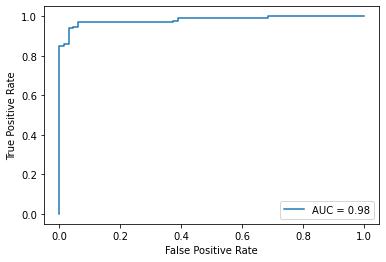

In [39]:
# Obtención de curva ROC y su respectivo AUC

from sklearn import metrics
from sklearn.metrics import roc_auc_score

y_prob = output.squeeze().detach().numpy()
auc = roc_auc_score(y_test,y_prob)
curve = metrics.roc_curve(y_test,y_prob)


display = metrics.RocCurveDisplay(fpr=curve[0], tpr=curve[1], roc_auc=auc)
display.plot()  

## Conclusiones

A modo de resumen, la metodología de entrenamiento del modelo corresponde a:
1. Importación de datos
2. Preprocesamiento de datos
3. Creación del vocabulario de entrenamiento
4. Estandarización de largo de reclamos
5. Creación de sets de entrenamiento, validación y test
6. Creación de batch de entrenamiento
7. Intanciamiento de arquitecura del modelo y sus hiperparámetros
8. Entrenamiento del modelo
9. Obtención de métricas

El modelo obtenido a partir de este proceso de entrenamiento obtuvo las siguientes métricas en el set de test:
* Accuracy de 95%
* F1 Score de 93%
* AUC de 98%

A partir de dichos valores, se puede obtener una aproximación de la performance del modelo en un set de datos fuera de los 1000 reclamos provistos con etiqueta. Sin embargo, dado que el modelo fue entrenado con este pequeño número de ejemplos, las métricas obtenidas son sólo una referencia. A medida que el modelo sea entrenado con un mayor volumen de datos, se puede obtener una mayor certeza de que las métricas de entrenamiento representen correctamente su performance con nuevos reclamos.